# Imports

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Preprocessing

In [56]:
metadata = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
metadata['file_path'] = metadata.apply(
    lambda row: f"UrbanSound8K/audio/fold{row['fold']}/{row['slice_file_name']}",
    axis=1
)

In [57]:
def extract_melspec_features(file_path, sr=20000, duration=4, n_mels=128):
    audio, sample_rate = librosa.load(file_path, sr=sr)
    target_length = int(duration * sample_rate)
    audio_data = librosa.util.fix_length(audio, size=target_length)
    
    hop_length = 512
    n_fft = 2048
    mel_spec = librosa.feature.melspectrogram(
        y=audio_data, 
        sr=sample_rate, 
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db.flatten()

In [58]:
if Path("extracted_melspec_features_cache.pkl").exists():
    with open("extracted_melspec_features_cache.pkl", 'rb') as f:
        cache_data = pickle.load(f)
    X = cache_data['features']
    y = cache_data['labels']
    file_paths = cache_data['file_paths']
else:
    features = []
    labels = []
    file_paths = []
    
    for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Extracting features"):
        f = extract_melspec_features(row['file_path'])
        features.append(f)
        labels.append(row['class'])
        file_paths.append(row['file_path'])
    
    X = np.array(features)
    y = np.array(labels)
    
    cache_data = {'features': X, 'labels': y, 'file_paths': file_paths}
    with open("extracted_melspec_features_cache.pkl", 'wb') as f:
        pickle.dump(cache_data, f)

In [59]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Modeling

In [60]:
model = RandomForestClassifier(
    n_estimators=250,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_pca, y_train_resampled)

y_pred = model.predict(X_test_pca)

results = {
    'confusion_matrix': confusion_matrix(y_test, y_pred),
    'classification_report': classification_report(y_test, y_pred, target_names=label_encoder.classes_)
}

print(results['classification_report'])

                  precision    recall  f1-score   support

 air_conditioner       0.83      0.83      0.83       200
        car_horn       0.69      0.71      0.70        86
children_playing       0.60      0.59      0.60       200
        dog_bark       0.81      0.69      0.74       200
        drilling       0.82      0.76      0.79       200
   engine_idling       0.85      0.84      0.85       200
        gun_shot       0.75      0.88      0.81        75
      jackhammer       0.74      0.82      0.78       200
           siren       0.85      0.85      0.85       186
    street_music       0.67      0.70      0.69       200

        accuracy                           0.76      1747
       macro avg       0.76      0.77      0.76      1747
    weighted avg       0.77      0.76      0.76      1747



# Results

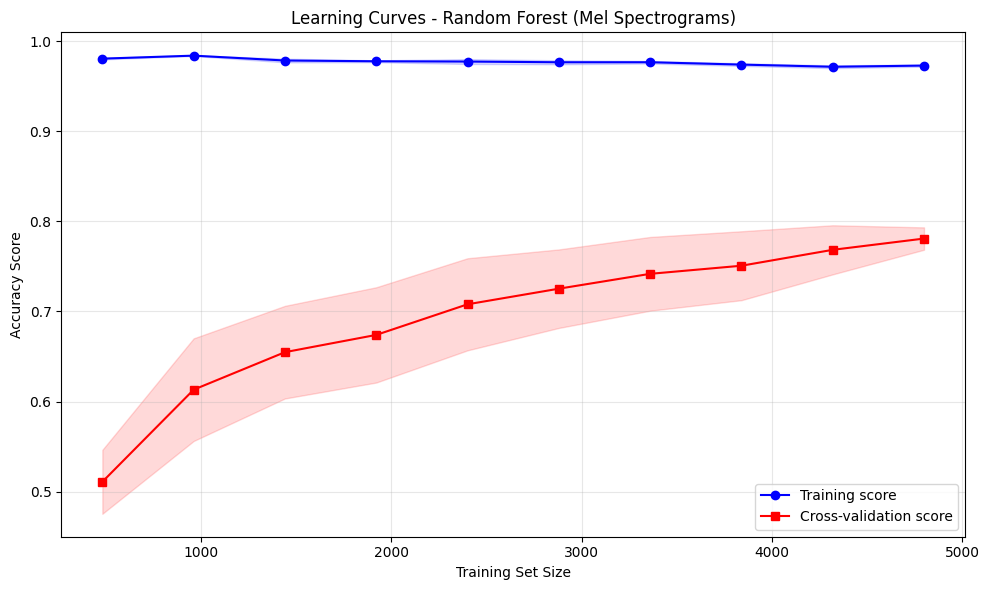

In [61]:
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_pca, y_train_resampled,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, label='Cross-validation score', color='red', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves - Random Forest (Mel Spectrograms)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_curves_melspec.png', dpi=300, bbox_inches='tight')
plt.show()

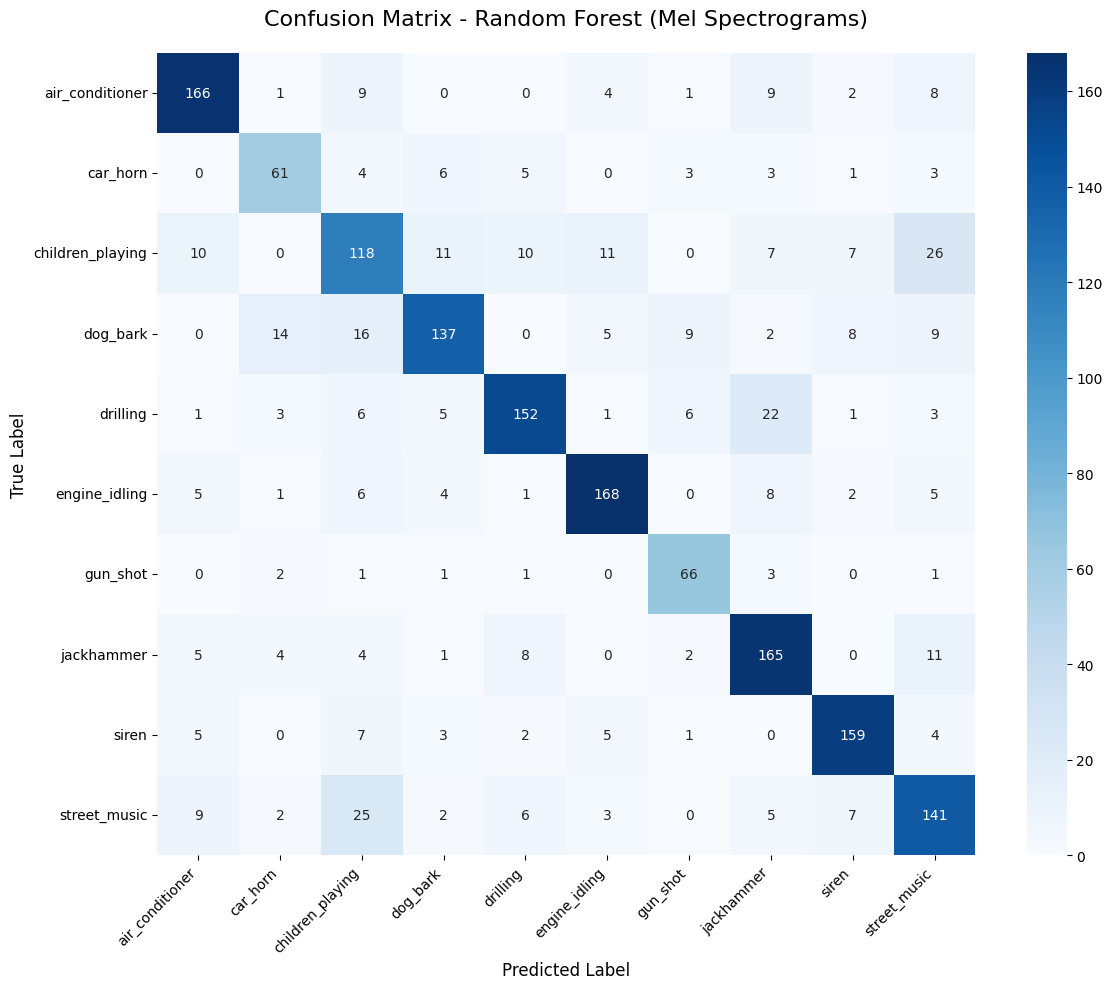

In [62]:
plt.figure(figsize=(12, 10))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Random Forest (Mel Spectrograms)', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_melspec.png', dpi=300, bbox_inches='tight')
plt.show()